In [1]:
import numpy as np
import healpy as hp
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gsp
from afra.tools.aux import Mbpconv_t, Mbpconv_eb
import warnings
warnings.filterwarnings('ignore')

#### estimate band-width functions according to given mask

In [2]:
%%time
mask = hp.read_map('./data/ali_mask.fits',dtype=np.float32,verbose=0)

NSIDE = 128

if os.path.isfile('./data/M_t.npy'):
    M_t = np.fromfile('./data/M_t.npy').reshape(3*NSIDE,-1)
    M_eb = np.fromfile('./data/M_eb.npy').reshape(3*NSIDE,-1)
else:
    M_t = Mbpconv_t(NSIDE,mask,20)
    M_eb = Mbpconv_eb(NSIDE,mask,20)
    M_t.tofile('./data/M_t.npy')
    M_eb.tofile('./data/M_eb.npy')

CPU times: user 378 ms, sys: 40.5 ms, total: 418 ms
Wall time: 423 ms


In [7]:
M_t = np.fromfile('M_t_wigner.npy').reshape(200,-1)

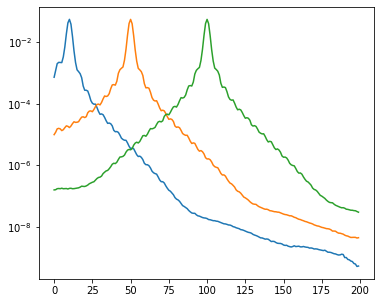

In [8]:
fig,ax = plt.subplots(figsize=(6,5))

ax.plot(M_t.T[10])
ax.plot(M_t.T[50])
ax.plot(M_t.T[100])
#ax.plot(M_t.T[200])
#ax.plot(M_t.T[300])

ax.set_yscale('log')

#### apply band-width functions on fiducial CMB spectrum

In [17]:
cl_cmb = hp.read_cl('./data/camb_cls.fits')

mask = hp.read_map('./data/ali_mask.fits',dtype=np.float32,verbose=0)
NSIDE = 128

resamp = 50
cl_true = np.zeros((resamp,3,3*NSIDE))
cl_raw = np.zeros_like(cl_true)
cl_rec = np.zeros_like(cl_true)
for i in range(resamp):
    map_realization = hp.synfast(cl_cmb,nside=NSIDE,new=True,verbose=0)
    cl_true[i] = hp.anafast(map_realization)[:3]
    map_masked = map_realization*mask
    cl_raw[i] = hp.anafast(map_masked)[:3]
    cl_rec[i][0][:200] = M_t.dot(cl_true[i][0][:200])
    #cl_rec[i][1:] = M_eb.dot(np.r_[cl_true[i][1],cl_true[i][2]]).reshape(2,-1)

"\nfig,ax = plt.subplots(figsize=(6,5))\n\nfor i in range(resamp):\n    ax.scatter(ell,(cl_raw[i][1]-cl_raw_mean[1])/cl_raw_mean[1],color='orange',marker='.')\n    ax.scatter(ell,(cl_rec[i][1]-cl_raw_mean[1])/cl_raw_mean[1],color='green',marker='.')\n\nax.plot((0,3*NSIDE),(0,0),'k--')\nax.set_xscale('log')\nax.set_xlim((2,3*NSIDE))\nax.set_ylim((-0.5,0.5))\nax.set_title('E mode')\n\nfig,ax = plt.subplots(figsize=(6,5))\n\nfor i in range(resamp):\n    ax.scatter(ell,(cl_raw[i][2]-cl_raw_mean[2])/cl_raw_mean[2],color='orange',marker='.')\n    ax.scatter(ell,(cl_rec[i][2]-cl_raw_mean[2])/cl_raw_mean[2],color='green',marker='.')\n\nax.plot((0,3*NSIDE),(0,0),'k--')\nax.set_xscale('log')\nax.set_xlim((2,3*NSIDE))\nax.set_ylim((-0.5,0.5))\nax.set_title('B mode')\n"

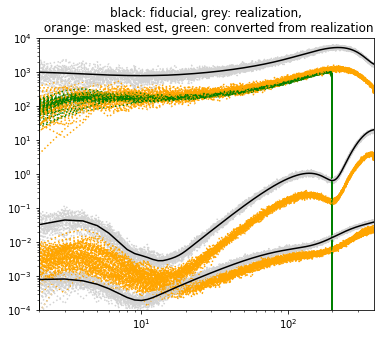

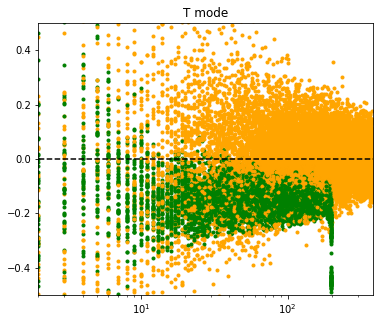

In [19]:
ell = np.arange(3*NSIDE)
coef = 0.5*ell*(ell+1)/np.pi


fig,ax = plt.subplots(figsize=(6,5))

for i in range(resamp):
    ax.plot(ell,coef*cl_true[i][0],color='lightgrey',linestyle=':')
    ax.plot(ell,coef*cl_true[i][1],color='lightgrey',linestyle=':')
    ax.plot(ell,coef*cl_true[i][2],color='lightgrey',linestyle=':')
    
    ax.plot(ell,coef*cl_raw[i][0],color='orange',linestyle=':')
    ax.plot(ell,coef*cl_raw[i][1],color='orange',linestyle=':')
    ax.plot(ell,coef*cl_raw[i][2],color='orange',linestyle=':')
    
    ax.plot(ell,coef*cl_rec[i][0],color='green',linestyle=':')
    ax.plot(ell,coef*cl_rec[i][1],color='green',linestyle=':')
    ax.plot(ell,coef*cl_rec[i][2],color='green',linestyle=':')

ax.plot(ell,coef*cl_cmb[0][:3*NSIDE],'k-')
ax.plot(ell,coef*cl_cmb[1][:3*NSIDE],'k-')
ax.plot(ell,coef*cl_cmb[2][:3*NSIDE],'k-')

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim((2,3*NSIDE))
ax.set_ylim((1e-4,1e4))
ax.set_title('black: fiducial, grey: realization,\n orange: masked est, green: converted from realization')


cl_raw_mean = cl_raw[0].copy()
for i in range(1,resamp):
    cl_raw_mean += cl_raw[i]
cl_raw_mean /= resamp


fig,ax = plt.subplots(figsize=(6,5))

for i in range(resamp):
    ax.scatter(ell,(cl_raw[i][0]-cl_raw_mean[0])/cl_raw_mean[0],color='orange',marker='.')
    ax.scatter(ell,(cl_rec[i][0]-cl_raw_mean[0])/cl_raw_mean[0],color='green',marker='.')

ax.plot((0,3*NSIDE),(0,0),'k--')
ax.set_xscale('log')
ax.set_xlim((2,3*NSIDE))
ax.set_ylim((-0.5,0.5))
ax.set_title('T mode')

'''
fig,ax = plt.subplots(figsize=(6,5))

for i in range(resamp):
    ax.scatter(ell,(cl_raw[i][1]-cl_raw_mean[1])/cl_raw_mean[1],color='orange',marker='.')
    ax.scatter(ell,(cl_rec[i][1]-cl_raw_mean[1])/cl_raw_mean[1],color='green',marker='.')

ax.plot((0,3*NSIDE),(0,0),'k--')
ax.set_xscale('log')
ax.set_xlim((2,3*NSIDE))
ax.set_ylim((-0.5,0.5))
ax.set_title('E mode')

fig,ax = plt.subplots(figsize=(6,5))

for i in range(resamp):
    ax.scatter(ell,(cl_raw[i][2]-cl_raw_mean[2])/cl_raw_mean[2],color='orange',marker='.')
    ax.scatter(ell,(cl_rec[i][2]-cl_raw_mean[2])/cl_raw_mean[2],color='green',marker='.')

ax.plot((0,3*NSIDE),(0,0),'k--')
ax.set_xscale('log')
ax.set_xlim((2,3*NSIDE))
ax.set_ylim((-0.5,0.5))
ax.set_title('B mode')
'''

end